In [171]:
import numpy as np


# import lumicks


import lumicks.pylake as lk



# %matplotlib inline


from skimage.transform import rescale
import tifffile
import os



from cv2 import warpAffine


from pathlib import Path


from picasso import io, postprocess



from json import JSONEncoder


import argparse


import shutil



def norm_image(image, inverse=False):
    amin = image.min()

    amax = image.max()

    if inverse:
        return 1 - (image - amin) / (amax - amin)

    else:
        return (image - amin) / (amax - amin)



class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()

        return JSONEncoder.default(self, obj)

In [172]:
# Just to test without arguments

# irm_path = "data/20231228-A_IRM_0.5_beads.tif" #Reference for calculation
# wt_path =   "data/20231228-A_WT_0.5_beads.tif"

movie_path = "data/20240112-113918_WT_0.5nM_15min_po_dodatku_LT_1.tiff"  # Test images
output_path = "output/"
# transform_matrix_exists=True
# transform_matrix = "transform_matrix_no_padding.json"
max_photons_exists = False
max_photons = 800000
min_gradient = 6000
box_size = 31
fit_method = "lq"
max_pos_error = 3.5

In [173]:
os.makedirs(output_path, exist_ok=True)

In [174]:
# Copy movie file to output and rename to tif

shutil.copy2(movie_path, output_path + os.path.basename(movie_path))

movie_path = output_path + os.path.basename(movie_path)

# rename tiff to tif files
if movie_path.endswith(".tiff"):
    os.rename(movie_path, movie_path[:-1])
    movie_path = movie_path[:-1]

FileNotFoundError: [Errno 2] No such file or directory: 'data/20240112-113918_WT_0.5nM_15min_po_dodatku_LT_1.tif'

In [7]:
movie = lk.ImageStack(movie_path)  # Loading a stack.

movie.export_tiff(
    output_path + Path(movie_path).stem + "_aligned.tif"
)  # Save aligned wt stack

In [162]:
# Get channel g
movie_r = movie.get_image(channel="red")
movie_g = movie.get_image(channel="green")
movie_b = movie.get_image(channel="blue")

movie_r_path = output_path + Path(movie_path).stem + "_r.tif"
movie_g_path = output_path + Path(movie_path).stem + "_g.tif"
movie_b_path = output_path + Path(movie_path).stem + "_b.tif"


# tifffile.imwrite(movie_r_path, movie_r)  #no need to export these
tifffile.imwrite(movie_g_path, movie_g)
# tifffile.imwrite(movie_b_path, movie_b)

# plt.imshow(movie_r[0], alpha=0.3, cmap="Reds")
# plt.imshow(movie_g[0], alpha=0.3, cmap="Greens")
# plt.imshow(movie_b[0], alpha=0.3, cmap="Blues")

In [11]:
run_string = (
        "python -m picasso localize "
        + movie_g_path
        + " --fit-method "
        + fit_method
        + " -b "
        + str(box_size)        
        + " --gradient "        
        + str(min_gradient)
    )
#subprocess.run(run_string)

!python -m picasso localize $movie_g_path --fit-method $fit_method -b  $box_size --gradient $min_gradient

    ____  _____________   __________ ____ 
   / __ \/  _/ ____/   | / ___/ ___// __ \
  / /_/ // // /   / /| | \__ \\__ \/ / / /
 / _____/ // /___/ ___ |___/ ___/ / /_/ / 
/_/   /___/\____/_/  |_/____/____/\____/  
                                          
Localize - Parameters:
No       Label           Value     
1        command         localize  
2        files           output/20240112-113918_WT_0.5nM_15min_po_dodatku_LT_1_g.tif
3        box_side_length 31        
4        fit_method      lq        
5        gradient        6000      
6        drift           1000      
7        roi             None
8        baseline        0         
9        sensitivity     1         
10       gain            1         
11       qe              1         
12       mf              0         
13       pixelsize       130       
14       zc                        
15       suffix                    
16       database        0         
------------------------------------------
Namespace(command='lo


LQ fitting: 100%|██████████| 1200/1200 [00:17<00:00, 67.34task/s] 

Generating segments: 100%|██████████| 1/1 [00:01<00:00,  1.81s/segments]

Correlating image pairs: 0pairs [00:00, ?pairs/s]
Correlating image pairs: 0pairs [00:00, ?pairs/s]


Correlating image pairs: 100%|██████████| 6/6 [00:00<00:00, 87.40pairs/s]


(-0.7703484, 2.598244)


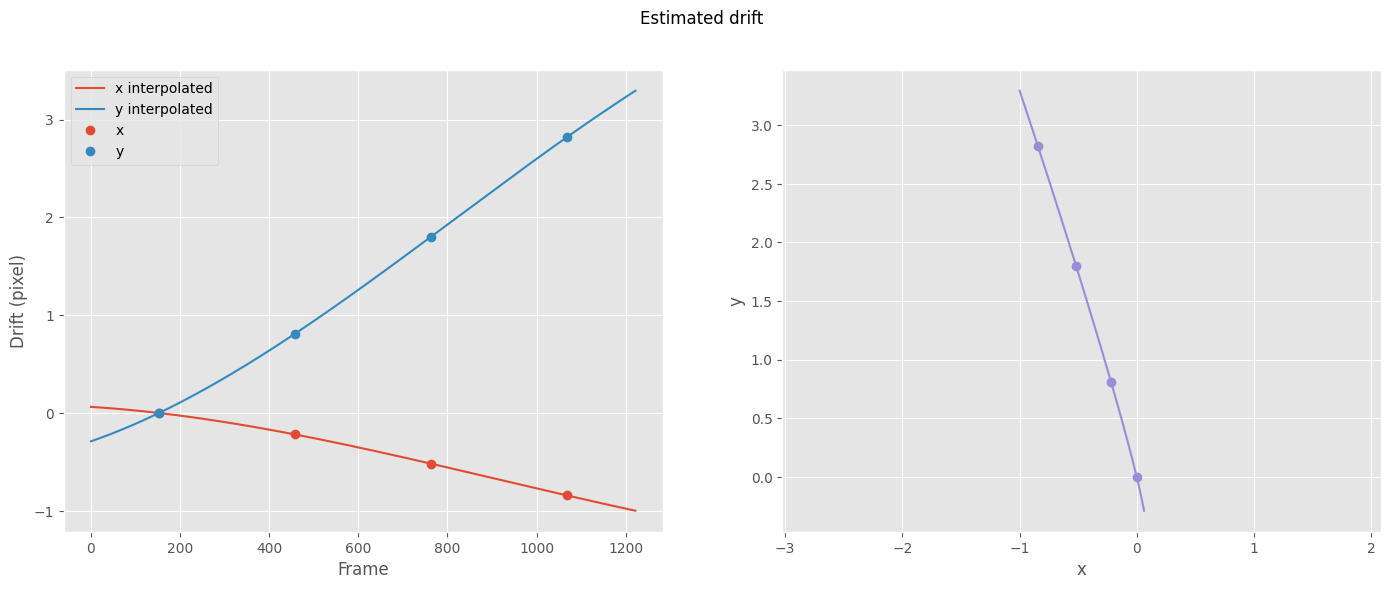

In [122]:
# Get shift

locs_path = output_path + Path(movie_g_path).stem + "_locs.hdf5"
yaml_path = output_path + Path(movie_g_path).stem + "_locs.yaml"

locs, info = io.load_locs(locs_path)

post_results = postprocess.undrift(locs, info, segmentation=300)
print(post_results[0][1000])

In [156]:
# Transform using affine transform

undrifted_movie_r = np.copy(movie_r)
undrifted_movie_g = np.copy(movie_g)
undrifted_movie_b = np.copy(movie_b)


scaling_matrix = np.array([[1, 0], [0, 1]])

rotation_matrix = np.array([[1, 0], [0, 1]])

shearing_matrix = np.array([[1, 0], [0, 1]])


for frame in range(0, len(post_results[0])):
    # print(, post_results[frame][0][1])
    # undrifted_frame = np.copy(undrifted_)
    x_displacement = -post_results[0][frame][0]
    y_displacement = -post_results[0][frame][1]
    translation_matrix = np.array([[x_displacement], [y_displacement]])
    # Combine all transformations into a single transformation matrix
    transform_mat = np.hstack(
        (scaling_matrix.dot(rotation_matrix).dot(shearing_matrix), translation_matrix)
    )
    undrifted_frame_r = warpAffine(
        movie_r[frame],
        transform_mat,
        (movie_r[frame].shape[1], movie_r[frame].shape[0]),
    )
    undrifted_frame_g = warpAffine(
        movie_g[frame],
        transform_mat,
        (movie_g[frame].shape[1], movie_g[frame].shape[0]),
    )

    undrifted_frame_b = warpAffine(
        movie_b[frame],
        transform_mat,
        (movie_b[frame].shape[1], movie_b[frame].shape[0]),
    )
    undrifted_movie_r[frame] = undrifted_frame_r
    undrifted_movie_g[frame] = undrifted_frame_g
    undrifted_movie_b[frame] = undrifted_frame_b

In [ ]:
# Output images

# movie_r_undrifted_path = output_path + Path(movie_r_path).stem + "_undrifted.tif"  #In case we want to export individual channels
# movie_g_undrifted_path = output_path + Path(movie_g_path).stem + "_undrifted.tif"  #In case we want to export individual channels
# movie_b_undrifted_path = output_path + Path(movie_b_path).stem + "_undrifted.tif"  #In case we want to export individual channels

# tifffile.imwrite(movie_r_undrifted_path, undrifted_movie_r)
# tifffile.imwrite(movie_g_undrifted_path, undrifted_movie_g)
# tifffile.imwrite(movie_b_undrifted_path, undrifted_movie_b)

stacked_image = np.stack(
    [undrifted_movie_r, undrifted_movie_g, undrifted_movie_b], axis=1
)  # Save stacked g and irm image

#  print(stacked_image.shape)

tifffile.imwrite(
    output_path + Path(movie_path).stem + "_undrifted.tif",
    np.float32(stacked_image),
    imagej=True,
    metadata={
        "Composite mode": "composite",
    },
)

In [165]:
movie._src.close()
os.remove(movie_path)
os.remove(locs_path)
os.remove(yaml_path)
os.remove(movie_g_path)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'data/20240112-113918_WT_0.5nM_15min_po_dodatku_LT_1.tif'